# COMP4318/5318 Assignment 2: Image Classification

### Group number: ...  , SID1: ... , SID2: ..., SID3: ... 

This template notebook includes code to load the  dataset and a skeleton for the main sections that should be included in the notebook. Please stick to this struture for your submitted notebook.

Please focus on making your code clear, with appropriate variable names and whitespace. Include comments and markdown text to aid the readability of your code where relevant. See the specification and marking criteria in the associated specification to guide you when completing your implementation.

## Setup and dependencies
Please use this section to list and set up all your required libraries/dependencies and your plotting environment. 

In [3]:
import psutil; print(psutil.Process().memory_info().rss/1024/1024, "MB")
import psutil, math
vm = psutil.virtual_memory()
print("Available:", round(vm.available/1024/1024), "MB")


107.703125 MB
Available: 6604 MB


In [4]:
import sys, platform, tensorflow as tf
print("Python:", sys.version)
print("Platform:", platform.platform())
print("TensorFlow:", tf.__version__)
print("Devices:", tf.config.list_physical_devices())


C:\Users\Ezio\anaconda3\envs\comp5318-tf\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(



Python: 3.10.18 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:08:55) [MSC v.1929 64 bit (AMD64)]
Platform: Windows-10-10.0.26100-SP0
TensorFlow: 2.15.0
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [6]:
# ==== Setup: imports & seeds ====
import os, time, json, random, csv, datetime
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import pandas as pd

# Reproducibility
SEED = 42
np.random.seed(SEED); random.seed(SEED); tf.keras.utils.set_random_seed(SEED)

## 1. Data loading, exploration, and preprocessing


Code to load the dataset is provided in the following cell. Please proceed with your data exploration and preprocessing in the remainder of this section.

In [7]:
# Load the dataset training and test sets as numpy arrays
# assuming Assignment2Data folder is present in the same directory 
# as the notebook

# ==== Load provided CIFAR-10 numpy arrays ====
X_train = np.load('Assignment2Data/X_train.npy')
y_train = np.load('Assignment2Data/y_train.npy')
X_test  = np.load('Assignment2Data/X_test.npy')
y_test  = np.load('Assignment2Data/y_test.npy')

print("Loaded:", X_train.shape, X_train.dtype, y_train.shape, y_train.dtype,
      "|", X_test.shape, X_test.dtype, y_test.shape, y_test.dtype)

# ==== Make a fixed 5,000-image validation set (stratified) ====
sss = StratifiedShuffleSplit(n_splits=1, test_size=5000, random_state=SEED)
train_idx, val_idx = next(sss.split(X_train, y_train))
X_tr, y_tr = X_train[train_idx], y_train[train_idx]
X_val, y_val = X_train[val_idx],  y_train[val_idx]
X_te,  y_te  = X_test,            y_test

# ==== Preprocess: /255.0 normalization (no aug for val/test) ====
def to_float01(x): 
    return (x.astype('float32') / 255.0)

X_tr = to_float01(X_tr); X_val = to_float01(X_val); X_te = to_float01(X_te)

# ==== tf.data pipelines ====
AUTO = tf.data.AUTOTUNE

def augment(image, label):
    # random crop with 4px padding + horizontal flip (train only)
    image = tf.pad(image, [[4,4],[4,4],[0,0]], mode='REFLECT')
    image = tf.image.random_crop(image, size=[32,32,3], seed=SEED)
    image = tf.image.random_flip_left_right(image, seed=SEED)
    return image, label

DEFAULT_BATCH = 128  # can be overridden later

def make_datasets(batch_size=DEFAULT_BATCH):
    train_ds = tf.data.Dataset.from_tensor_slices((X_tr, y_tr))\
        .shuffle(10000, seed=SEED, reshuffle_each_iteration=True)\
        .map(augment, num_parallel_calls=AUTO)\
        .batch(batch_size).prefetch(AUTO)
    val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val))\
        .batch(batch_size).cache().prefetch(AUTO)    # + cache
    test_ds  = tf.data.Dataset.from_tensor_slices((X_te,  y_te ))\
        .batch(batch_size).cache().prefetch(AUTO)    # + cache
    return train_ds, val_ds, test_ds


train_ds, val_ds, test_ds = make_datasets(DEFAULT_BATCH)

Loaded: (50000, 32, 32, 3) uint8 (50000,) int64 | (10000, 32, 32, 3) uint8 (10000,) int64


### Examples of preprocessed data
Please print/display some examples of your preprocessed data here.

X_train: shape=(50000, 32, 32, 3), dtype=uint8, min=0.000, max=255.000, ~146.5 MB


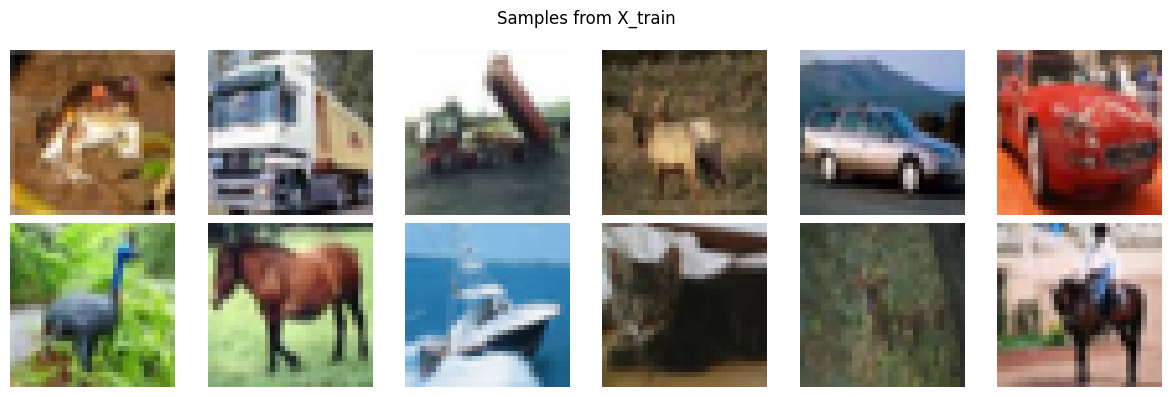

X_test: shape=(10000, 32, 32, 3), dtype=uint8, min=0.000, max=255.000, ~29.3 MB


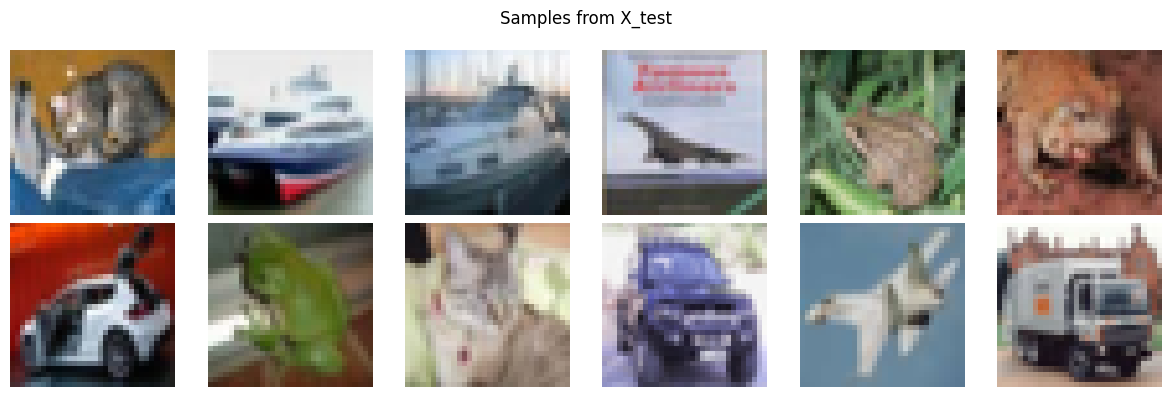

y_train: {0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000}
y_test : {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}
X_train (with labels): shape=(50000, 32, 32, 3), dtype=uint8, min=0.000, max=255.000, ~146.5 MB


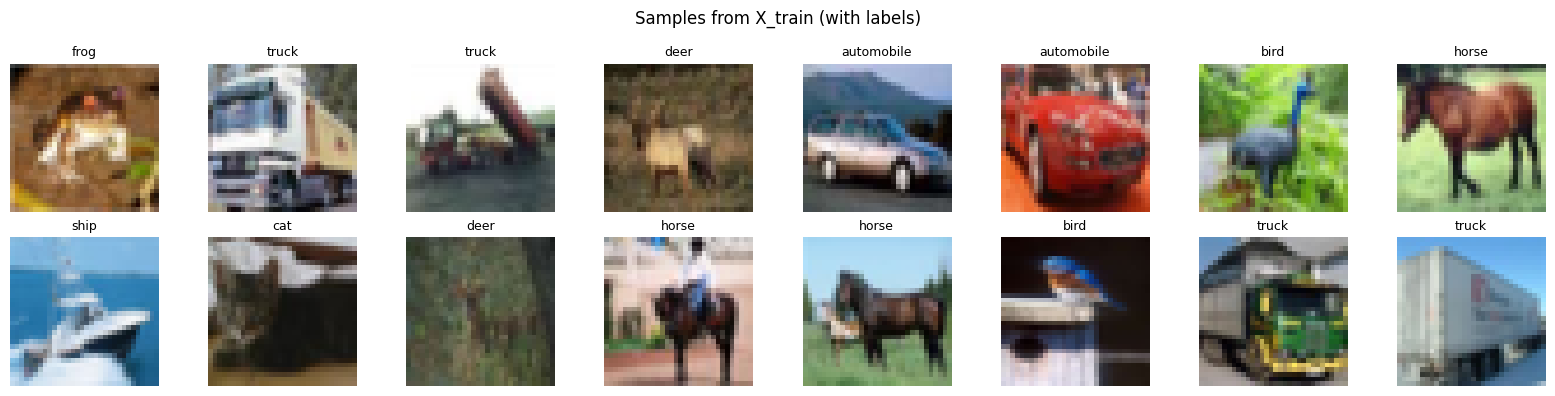

In [8]:
# ==== Peek into NPY contents (quick EDA) ====
import numpy as np, matplotlib.pyplot as plt, math

def peek_array(arr, name="array", n_show=12, cols=6, labels=None, label_map=None):
    """Print basic stats and (if RGB images) show a grid of samples."""
    flat_nbytes = arr.nbytes / 1024 / 1024
    print(f"{name}: shape={arr.shape}, dtype={arr.dtype}, "
          f"min={arr.min():.3f}, max={arr.max():.3f}, ~{flat_nbytes:.1f} MB")

    # If looks like images: (N, H, W, 3)
    is_rgb = (arr.ndim == 4 and arr.shape[-1] in (1,3) and arr.shape[1] <= 256 and arr.shape[2] <= 256)
    if is_rgb:
        n = min(n_show, arr.shape[0])
        rows = math.ceil(n / cols)
        plt.figure(figsize=(cols*2, rows*2))
        for i in range(n):
            ax = plt.subplot(rows, cols, i+1)
            img = arr[i]
            # handle float arrays in [0,1]
            if arr.dtype.kind == "f":
                img = np.clip(img, 0.0, 1.0)
            ax.imshow(img.squeeze())
            ax.axis("off")
            if labels is not None:
                lab = labels[i]
                if label_map:
                    lab = label_map.get(int(lab), int(lab))
                ax.set_title(str(lab), fontsize=9)
        plt.suptitle(f"Samples from {name}", y=0.98)
        plt.tight_layout()
        plt.show()

# 1)
peek_array(X_train, "X_train")
peek_array(X_test,  "X_test")

# 2) 
unique, counts = np.unique(y_train, return_counts=True)
print("y_train:", dict(zip(unique.tolist(), counts.tolist())))
unique, counts = np.unique(y_test, return_counts=True)
print("y_test :", dict(zip(unique.tolist(), counts.tolist())))

# 3) 
cifar10_label_to_text = {0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",
                         5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}
peek_array(X_train, "X_train (with labels)", n_show=16, cols=8,
           labels=y_train, label_map=cifar10_label_to_text)



## 2. Algorithm design and setup

### Algorithm of choice from first six weeks of course

### Fully connected neural network

### Convolutional neural network

In [9]:
# ==== CNN model factory (small & clear) ====
def make_cnn(filters_base=32, dropout=0.3, weight_decay=0.0):
    wd = keras.regularizers.l2(weight_decay) if weight_decay > 0 else None
    inputs = keras.Input(shape=(32,32,3))
    x = keras.layers.Conv2D(filters_base, 3, padding='same', use_bias=False, kernel_regularizer=wd)(inputs)
    x = keras.layers.BatchNormalization()(x); x = keras.layers.ReLU()(x)
    x = keras.layers.Conv2D(filters_base*2, 3, padding='same', use_bias=False, kernel_regularizer=wd)(x)
    x = keras.layers.BatchNormalization()(x); x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPool2D()(x)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Conv2D(filters_base*4, 3, padding='same', use_bias=False, kernel_regularizer=wd)(x)
    x = keras.layers.BatchNormalization()(x); x = keras.layers.ReLU()(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    outputs = keras.layers.Dense(10, activation='softmax')(x)
    return keras.Model(inputs, outputs)

# ==== One-pass training helper ====
def train_once(filters_base=32, dropout=0.3, weight_decay=0.0,
               lr=1e-3, batch_size=256, epochs=30, verbose=2):
    train_ds, val_ds, _ = make_datasets(batch_size)
    model = make_cnn(filters_base, dropout, weight_decay)
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6, min_delta=0.002, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-5),
    ]
    t0 = time.time()
    hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks, verbose=verbose)
    elapsed = time.time() - t0
    val_acc = float(np.max(hist.history['val_accuracy']))
    return model, hist, val_acc, elapsed

# ==== Plot learning curves (acc) ====
def plot_curves(history, out_path='learning_curves_cnn.png', title='CNN Learning Curves'):
    plt.figure()
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title(title)
    plt.tight_layout(); plt.savefig(out_path, dpi=180)
    plt.close()

In [15]:
# ==== Train a baseline ====
baseline_model, baseline_hist, baseline_val_acc, baseline_time = train_once(
    filters_base=32, dropout=0.3, weight_decay=0.0,
    lr=1e-3, batch_size=256, epochs=30, verbose=2
)
print(f"[Baseline] val_acc={baseline_val_acc:.4f} | time={baseline_time/60:.1f} min | params={baseline_model.count_params()/1e6:.2f}M")

plot_curves(baseline_hist, out_path='learning_curves_cnn.png')

Epoch 1/30
176/176 - 42s - loss: 1.6029 - accuracy: 0.4270 - val_loss: 3.6564 - val_accuracy: 0.1034 - lr: 0.0010 - 42s/epoch - 240ms/step
Epoch 2/30
176/176 - 41s - loss: 1.3575 - accuracy: 0.5225 - val_loss: 2.6138 - val_accuracy: 0.2342 - lr: 0.0010 - 41s/epoch - 233ms/step
Epoch 3/30
176/176 - 41s - loss: 1.2646 - accuracy: 0.5543 - val_loss: 1.5411 - val_accuracy: 0.4310 - lr: 0.0010 - 41s/epoch - 233ms/step
Epoch 4/30
176/176 - 40s - loss: 1.2090 - accuracy: 0.5731 - val_loss: 1.3399 - val_accuracy: 0.5234 - lr: 0.0010 - 40s/epoch - 229ms/step
Epoch 5/30
176/176 - 41s - loss: 1.1564 - accuracy: 0.5933 - val_loss: 1.6684 - val_accuracy: 0.4564 - lr: 0.0010 - 41s/epoch - 231ms/step
Epoch 6/30
176/176 - 41s - loss: 1.1239 - accuracy: 0.6045 - val_loss: 1.4589 - val_accuracy: 0.4978 - lr: 0.0010 - 41s/epoch - 235ms/step
Epoch 7/30
176/176 - 41s - loss: 1.0948 - accuracy: 0.6191 - val_loss: 1.2291 - val_accuracy: 0.5502 - lr: 0.0010 - 41s/epoch - 231ms/step
Epoch 8/30
176/176 - 41s - 

## 3. Hyperparameter tuning

### Algorithm of choice from first six weeks of course

### Fully connected neural network

### Convolutional neural network

In [16]:
# ==== Hyperparameter tuning (in-notebook, no external reads) ====

TRIALS_LOG = 'trials_cnn.csv'  # optional backup; final does not depend on it
if not os.path.exists(TRIALS_LOG):
    with open(TRIALS_LOG, 'w', newline='') as f:
        csv.writer(f).writerow([
            'model','trial_id','hyperparams_json','epochs_run','best_val_acc',
            'best_val_loss','train_time_sec','hardware','timestamp'
        ])

TRIALS_MEM = []  # [{trial_id, hp, best_val_acc, best_val_loss, epochs_run, train_time_sec}]

def sample_space_det(trial_id: int):
    rng = np.random.RandomState(SEED + trial_id)
    return {
        'lr':           10 ** rng.uniform(-4, -1.5),
        'filters_base': int(rng.choice([24, 32, 40])),
        'dropout':      float(rng.choice([0.2, 0.35, 0.5])),
        'weight_decay': float(rng.choice([1e-4, 5e-4, 1e-3])),
        'batch_size':   256,
    }

class EpochPing(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self._t0 = time.time()
    def on_epoch_end(self, epoch, logs=None):
        secs = time.time() - self._t0
        va = logs.get('val_accuracy', 0.0)
        print(f"  epoch {epoch+1}: {secs:.1f}s | val_acc={va:.4f}", flush=True)

def run_trial_det(trial_id, epochs_max=30, verbose=2):
    hp = sample_space_det(trial_id)
    print(f"[trial {trial_id:02d}] {hp}", flush=True)

    train_ds, val_ds, _ = make_datasets(hp['batch_size'])
    model = make_cnn(hp['filters_base'], hp['dropout'], hp['weight_decay'])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp['lr']),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-5),
        EpochPing(),
    ]
    t0 = time.time()
    hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs_max,
                     verbose=verbose, callbacks=callbacks)
    elapsed = time.time() - t0

    best_va = float(np.max(hist.history['val_accuracy']))
    best_vl = float(np.min(hist.history['val_loss']))
    rec = dict(trial_id=trial_id, hp=hp,
               best_val_acc=best_va, best_val_loss=best_vl,
               epochs_run=len(hist.history['val_accuracy']),
               train_time_sec=int(elapsed))
    TRIALS_MEM.append(rec)

    # optional CSV backup
    with open(TRIALS_LOG, 'a', newline='') as f:
        csv.writer(f).writerow([
            'cnn', trial_id, json.dumps(hp), rec['epochs_run'], best_va, best_vl,
            rec['train_time_sec'], str(tf.config.list_physical_devices()), datetime.datetime.now().isoformat()
        ])

    print(f"  done | epochs={rec['epochs_run']} | best_val_acc={best_va:.4f} | time={elapsed/60:.1f}m", flush=True)
    return best_va, hp

# run trials and select the best in-memory
N_TRIALS = 20
best_rec = None
for t in range(N_TRIALS):
    va, hp = run_trial_det(trial_id=t, epochs_max=30, verbose=2)
    if (best_rec is None) or (va > best_rec['best_val_acc']):
        best_rec = dict(trial_id=t, hp=hp, best_val_acc=va)

print("\nBest hparams (in-notebook):", best_rec['hp'], "| best_val_acc:", f"{best_rec['best_val_acc']:.4f}")

# quick plot + top-K table
df = pd.DataFrame(TRIALS_MEM)
df['lr']      = df['hp'].apply(lambda d: d['lr'])
df['filters'] = df['hp'].apply(lambda d: d['filters_base'])
df['drop']    = df['hp'].apply(lambda d: d['dropout'])
df['wd']      = df['hp'].apply(lambda d: d['weight_decay'])
df['bs']      = df['hp'].apply(lambda d: d['batch_size'])

markers = {128:'o', 256:'s'}
colors  = {24:'tab:blue', 32:'tab:orange', 40:'tab:green'}
plt.figure()
for _, r in df.iterrows():
    plt.scatter(r['lr'], r['best_val_acc'], c=colors[r['filters']],
                marker=markers.get(r['bs'],'o'), s=45, alpha=0.9)
best_idx = df['best_val_acc'].idxmax()
plt.scatter(df.loc[best_idx,'lr'], df.loc[best_idx,'best_val_acc'],
            facecolors='none', edgecolors='k', s=160, linewidths=1.8, label='best')
plt.xscale('log'); plt.xlabel('learning rate'); plt.ylabel('best val_acc')
plt.title('CNN tuning: LR vs val_acc')
plt.tight_layout(); plt.savefig('search_scatter_cnn_lr_inmem.png', dpi=180); plt.close()

K = 5
topk = df.sort_values('best_val_acc', ascending=False).head(K).copy()
cols = ['trial_id','best_val_acc','epochs_run','train_time_sec','lr','filters','drop','wd','bs']
print("\nTop-5 trials:\n", topk[cols].to_string(index=False,
      float_format=lambda x: f"{x:.4f}" if isinstance(x,float) else str(x)))


[start trial 0] {'lr': 0.0008636748975005902, 'filters_base': 40, 'dropout': 0.2, 'weight_decay': 0.0001, 'batch_size': 256}
Epoch 1/30
  ↳ epoch 1 done in 56.0s | val_acc=0.1072
176/176 - 56s - loss: 1.6172 - accuracy: 0.4277 - val_loss: 3.4865 - val_accuracy: 0.1072 - lr: 8.6367e-04 - 56s/epoch - 318ms/step
Epoch 2/30
  ↳ epoch 2 done in 54.5s | val_acc=0.2304
176/176 - 55s - loss: 1.3653 - accuracy: 0.5291 - val_loss: 2.5790 - val_accuracy: 0.2304 - lr: 8.6367e-04 - 55s/epoch - 310ms/step
Epoch 3/30
  ↳ epoch 3 done in 55.4s | val_acc=0.4010
176/176 - 55s - loss: 1.2631 - accuracy: 0.5646 - val_loss: 1.7294 - val_accuracy: 0.4010 - lr: 8.6367e-04 - 55s/epoch - 315ms/step
Epoch 4/30
  ↳ epoch 4 done in 56.6s | val_acc=0.4942
176/176 - 57s - loss: 1.1986 - accuracy: 0.5870 - val_loss: 1.3598 - val_accuracy: 0.4942 - lr: 8.6367e-04 - 57s/epoch - 321ms/step
Epoch 5/30
  ↳ epoch 5 done in 56.9s | val_acc=0.4790
176/176 - 57s - loss: 1.1487 - accuracy: 0.6048 - val_loss: 1.6000 - val_accu

## 4. Final models
In this section, please ensure to include cells to train each model with its best hyperparmater combination independently of the hyperparameter tuning cells, i.e. don't rely on the hyperparameter tuning cells having been run.

### Algorithm of choice from first six weeks of course

### Fully connected neural network

### Convolutional neural network

In [4]:
# === FINAL (TRAIN ONLY) — CNN retrain + test eval; no plots ===
import os, time, random, numpy as np, tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report

# seeds
SEED = 42
np.random.seed(SEED); random.seed(SEED); tf.keras.utils.set_random_seed(SEED)
AUTO = tf.data.AUTOTUNE

# data (expects NPYs under Assignment2Data/)
X_train = np.load('Assignment2Data/X_train.npy')
y_train = np.load('Assignment2Data/y_train.npy')
X_test  = np.load('Assignment2Data/X_test.npy')
y_test  = np.load('Assignment2Data/y_test.npy')

# fixed stratified 5k validation split
sss = StratifiedShuffleSplit(n_splits=1, test_size=5000, random_state=SEED)
tr_idx, val_idx = next(sss.split(X_train, y_train))
X_tr, y_tr = X_train[tr_idx], y_train[tr_idx]
X_val, y_val = X_train[val_idx], y_train[val_idx]
X_te,  y_te  = X_test,          y_test
y_tr = y_tr.astype('int32'); y_val = y_val.astype('int32'); y_te = y_te.astype('int32')

# preprocessing
def to_float01(x): return x.astype('float32')/255.0
X_tr = to_float01(X_tr); X_val = to_float01(X_val); X_te = to_float01(X_te)

# tf.data pipelines (train has light aug)
def augment(image, label):
    image = tf.pad(image, [[4,4],[4,4],[0,0]], mode='REFLECT')
    image = tf.image.random_crop(image, size=[32,32,3], seed=SEED)
    image = tf.image.random_flip_left_right(image, seed=SEED)
    image = tf.image.random_contrast(image, 0.9, 1.1)
    image = tf.image.random_brightness(image, 0.05)
    return image, label

def make_datasets(batch_size: int):
    train_ds = (tf.data.Dataset.from_tensor_slices((X_tr, y_tr))
                .shuffle(10000, seed=SEED, reshuffle_each_iteration=True)
                .map(augment, num_parallel_calls=AUTO)
                .batch(batch_size).prefetch(AUTO))
    val_ds   = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
                .batch(batch_size).cache().prefetch(AUTO))
    test_ds  = (tf.data.Dataset.from_tensor_slices((X_te,  y_te ))
                .batch(batch_size).cache().prefetch(AUTO))
    return train_ds, val_ds, test_ds

# model
def make_cnn(filters_base=32, dropout=0.35, weight_decay=5e-4):
    wd = keras.regularizers.l2(weight_decay) if weight_decay>0 else None
    inputs = keras.Input(shape=(32,32,3))
    x = keras.layers.Conv2D(filters_base, 3, padding='same', use_bias=False, kernel_regularizer=wd)(inputs)
    x = keras.layers.BatchNormalization()(x); x = keras.layers.ReLU()(x)
    x = keras.layers.Conv2D(filters_base*2, 3, padding='same', use_bias=False, kernel_regularizer=wd)(x)
    x = keras.layers.BatchNormalization()(x); x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPool2D()(x)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Conv2D(filters_base*4, 3, padding='same', use_bias=False, kernel_regularizer=wd)(x)
    x = keras.layers.BatchNormalization()(x); x = keras.layers.ReLU()(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    outputs = keras.layers.Dense(10, activation='softmax')(x)
    return keras.Model(inputs, outputs)

# loss: sparse CE with label smoothing (compat)
NUM_CLASSES = 10
def sparse_ce_with_ls(ls=0.1):
    cce = keras.losses.CategoricalCrossentropy(label_smoothing=ls)
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(tf.squeeze(y_true), tf.int32)
        y_true_oh = tf.one_hot(y_true, NUM_CLASSES)
        return cce(y_true_oh, y_pred)
    return loss_fn

def train_once(filters_base=32, dropout=0.35, weight_decay=5e-4,
               lr=3e-3, batch_size=256, epochs=12, verbose=2):
    train_ds, val_ds, _ = make_datasets(batch_size)
    model = make_cnn(filters_base, dropout, weight_decay)

    steps_per_epoch = int(np.ceil(len(X_tr) / batch_size))
    lr_sched = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=lr, decay_steps=steps_per_epoch * epochs, alpha=1e-5
    )
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_sched),
                  loss=sparse_ce_with_ls(0.1),
                  metrics=['accuracy'])
    callbacks = [keras.callbacks.EarlyStopping(
        monitor='val_accuracy', patience=3, min_delta=0.002, restore_best_weights=True
    )]
    t0 = time.time()
    hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs,
                     callbacks=callbacks, verbose=verbose)
    elapsed = time.time() - t0
    val_acc = float(np.max(hist.history['val_accuracy']))
    return model, hist, val_acc, elapsed

# hardcoded best hp (standalone)
best_hp = {'lr': 0.003, 'filters_base': 32, 'dropout': 0.35, 'weight_decay': 5e-4, 'batch_size': 256}
print("Using best_hp:", best_hp)

# train (with OOM fallback)
try:
    final_model, final_hist, final_val_acc, final_time = train_once(
        filters_base=best_hp['filters_base'],
        dropout=best_hp['dropout'],
        weight_decay=best_hp['weight_decay'],
        lr=best_hp['lr'],
        batch_size=best_hp['batch_size'],
        epochs=12, verbose=2
    )
except Exception as e:
    print(f"[warn] batch_size={best_hp['batch_size']} failed ({type(e).__name__}); retry 128")
    final_model, final_hist, final_val_acc, final_time = train_once(
        filters_base=best_hp['filters_base'],
        dropout=best_hp['dropout'],
        weight_decay=best_hp['weight_decay'],
        lr=best_hp['lr'],
        batch_size=128,
        epochs=12, verbose=2
    )

print(f"[Final] val_acc={final_val_acc:.4f} | time={final_time/60:.1f}m | params={final_model.count_params()/1e6:.2f}M")

# test (no plots)
_, _, test_ds = make_datasets(best_hp['batch_size'])
test_loss, test_acc = final_model.evaluate(test_ds, verbose=0)
print(f"[Test] acc={test_acc:.4f} | loss={test_loss:.4f}")

# predictions kept in memory for plots
y_prob = final_model.predict(test_ds, verbose=0)
# class names kept in memory as well
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']


Using best_hp: {'lr': 0.003, 'filters_base': 32, 'dropout': 0.35, 'weight_decay': 0.0005, 'batch_size': 256}
Epoch 1/12
176/176 - 44s - loss: 1.7749 - accuracy: 0.4429 - val_loss: 3.5139 - val_accuracy: 0.1220 - 44s/epoch - 249ms/step
Epoch 2/12
176/176 - 43s - loss: 1.5931 - accuracy: 0.5355 - val_loss: 2.3524 - val_accuracy: 0.2738 - 43s/epoch - 243ms/step
Epoch 3/12
176/176 - 40s - loss: 1.5303 - accuracy: 0.5690 - val_loss: 1.7491 - val_accuracy: 0.4698 - 40s/epoch - 229ms/step
Epoch 4/12
176/176 - 40s - loss: 1.4818 - accuracy: 0.5937 - val_loss: 1.6731 - val_accuracy: 0.5092 - 40s/epoch - 227ms/step
Epoch 5/12
176/176 - 40s - loss: 1.4382 - accuracy: 0.6163 - val_loss: 1.7488 - val_accuracy: 0.4672 - 40s/epoch - 230ms/step
Epoch 6/12
176/176 - 40s - loss: 1.4031 - accuracy: 0.6365 - val_loss: 1.5013 - val_accuracy: 0.5722 - 40s/epoch - 229ms/step
Epoch 7/12
176/176 - 40s - loss: 1.3671 - accuracy: 0.6543 - val_loss: 1.4018 - val_accuracy: 0.6308 - 40s/epoch - 229ms/step
Epoch 8/1

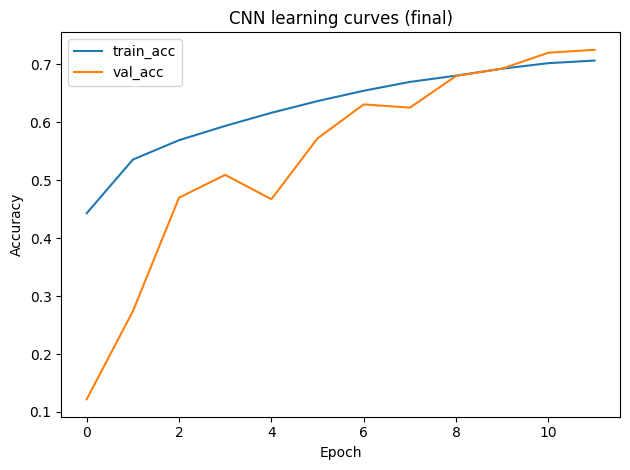

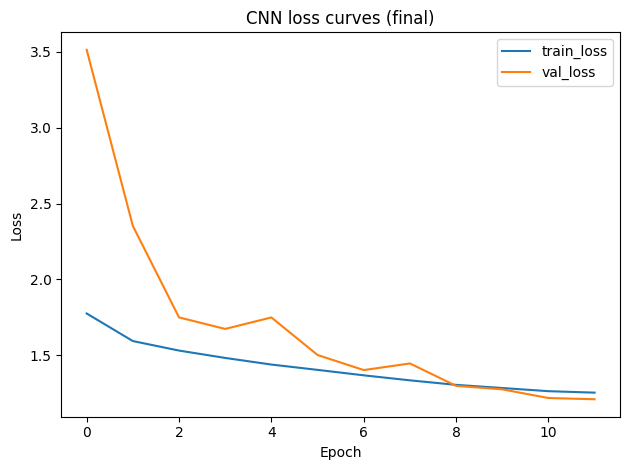

In [5]:
# === PLOT 1 — Learning curves (in-memory) ===
assert 'final_hist' in globals(), "Run the TRAIN ONLY cell first."
import matplotlib.pyplot as plt

plt.figure()
plt.plot(final_hist.history.get('accuracy', []), label='train_acc')
plt.plot(final_hist.history.get('val_accuracy', []), label='val_acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('CNN learning curves (final)')
plt.tight_layout(); plt.savefig('learning_curves_cnn_final.png', dpi=180); plt.show()

# (optional) Loss curves
if 'loss' in final_hist.history and 'val_loss' in final_hist.history:
    plt.figure()
    plt.plot(final_hist.history['loss'], label='train_loss')
    plt.plot(final_hist.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('CNN loss curves (final)')
    plt.tight_layout(); plt.savefig('loss_curves_cnn_final.png', dpi=180); plt.show()


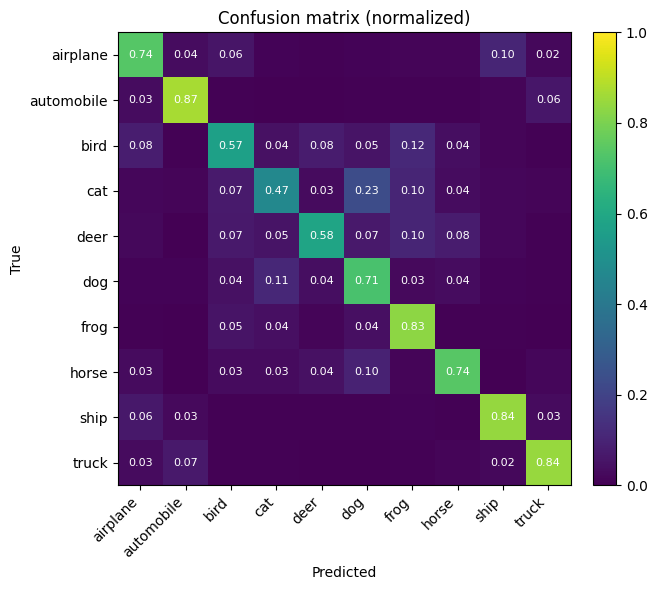

In [6]:
# PLOT 2 — Confusion matrix (uses in-memory `y_prob`, `y_te`)
assert 'y_prob' in globals() and 'y_te' in globals(), "Run the TRAIN ONLY cell first."
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# class names (reuse existing or define once)
if 'classes' not in globals():
    classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

y_pred = np.argmax(y_prob, axis=1)
cm = confusion_matrix(y_te, y_pred, normalize='true')

plt.figure(figsize=(7,6))
im = plt.imshow(cm, cmap='viridis', vmin=0.0, vmax=1.0)
plt.title('Confusion matrix (normalized)'); plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xlabel('Predicted'); plt.ylabel('True')
plt.xticks(range(len(classes)), classes, rotation=45, ha='right'); plt.yticks(range(len(classes)), classes)
for i in range(len(classes)):
    for j in range(len(classes)):
        if cm[i, j] > 0.02:
            plt.text(j, i, f"{cm[i,j]:.2f}", ha='center', va='center', color='white', fontsize=8)
plt.tight_layout(); plt.savefig('confmat_cnn_norm.png', dpi=180); plt.show()


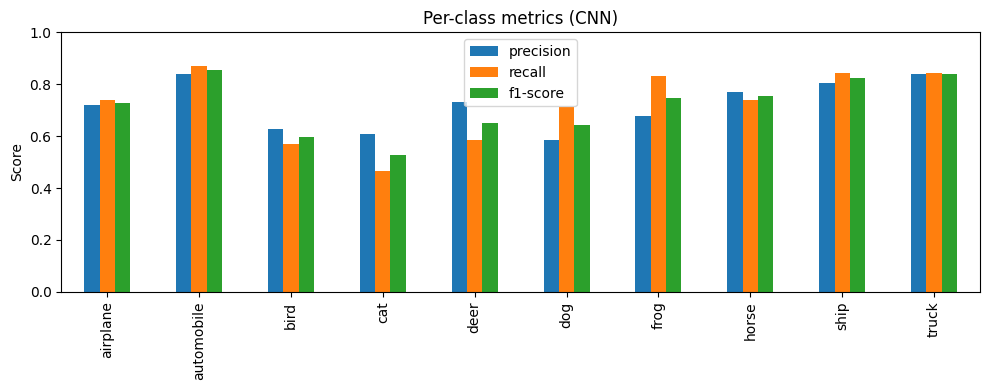

In [7]:
# PLOT 3 — Per-class metrics (uses in-memory `y_prob`, `y_te`)
assert 'y_prob' in globals() and 'y_te' in globals(), "Run the TRAIN ONLY cell first."
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# class names (reuse existing or define once)
if 'classes' not in globals():
    classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

y_pred = np.argmax(y_prob, axis=1)
rep = classification_report(y_te, y_pred, target_names=classes, output_dict=True)
rep_df = pd.DataFrame(rep).T.iloc[:len(classes)][['precision','recall','f1-score']]

ax = rep_df.plot(kind='bar', figsize=(10,4))
ax.set_title('Per-class metrics (CNN)')
ax.set_ylabel('Score'); ax.set_ylim(0,1.0)
plt.tight_layout(); plt.savefig('per_class_metrics_cnn.png', dpi=180); plt.show()
